Check FGW interpolation properties
---
The aim here is to check how diferent implementations of Fused Gromov-Wasserstein interpolate between Wasserstein (W) and Gromov-Wasserstein (GW) regimes. To do this, we'll use an example from [Vayer et al., Algorithms 2020](https://hal.archives-ouvertes.fr/hal-02971153):

![Fig. 10](fig_10.png "Title")

# Preliminaries

## Import packages

In [1]:
%load_ext autoreload
%autoreload 2

In [97]:
# import Jax, set to 64 bit precision
from jax import numpy as jnp
from jax.config import config
config.update("jax_enable_x64", True)

# import standard packages
import matplotlib.pyplot as plt
import numpy as np

# import OT packages
import moscot
import novosparc
import ott
from ott.geometry.geometry import Geometry
import ot # POT

## Simulate data

In [3]:
# taken from: https://pythonot.github.io/auto_examples/gromov/plot_fgw.html#sphx-glr-auto-examples-plot-fgw-py
n = 20  # number of points in the first distribution
n2 = 30  # number of points in the second distribution
sig = 1  # std of first distribution
sig2 = 0.1  # std of second distribution

np.random.seed(0)

# source data (s)
phi = np.arange(n)[:, None]
xs = phi + sig * np.random.randn(n, 1)
ys = np.vstack((np.ones((n // 2, 1)), 0 * np.ones((n // 2, 1)))) + sig2 * np.random.randn(n, 1)

# target data (t)
phi2 = np.arange(n2)[:, None]
xt = phi2 + sig * np.random.randn(n2, 1)
yt = np.vstack((np.ones((n2 // 2, 1)), 0 * np.ones((n2 // 2, 1)))) + sig2 * np.random.randn(n2, 1)
yt = yt[::-1, :]

## Visualize the data

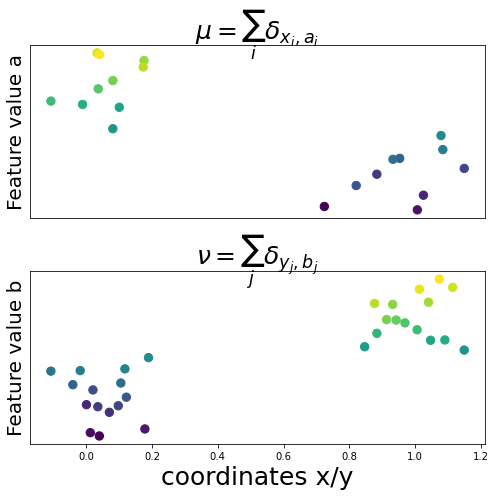

In [7]:
plt.close(10)
plt.figure(10, (7, 7))

plt.subplot(2, 1, 1)

plt.scatter(ys, xs, c=phi, s=70)
plt.ylabel('Feature value a', fontsize=20)
plt.title('$\mu=\sum_i \delta_{x_i,a_i}$', fontsize=25, y=1)
plt.xticks(())
plt.yticks(())

plt.subplot(2, 1, 2)

plt.scatter(yt, xt, c=phi2, s=70)
plt.xlabel('coordinates x/y', fontsize=25)
plt.ylabel('Feature value b', fontsize=20)
plt.title('$\\nu=\sum_j \delta_{y_j,b_j}$', fontsize=25, y=1)
plt.yticks(())

plt.tight_layout()
plt.show()

So we have a structure space, given by x and y, which is specific to each space. Also, we have a feature space which is shared. The featrue space is shown on the y-axis, and the color is just the y-value. 

# Implement utility functions

Below are the utilities we need for this comparison

In [187]:
def run_comparison(C1, C2, M, p, q, alpha=1e-3, log=True, epsilon=None, n_iters=20, tol=1e-9):
    
    # prepare cost matrices for moscot
    C1_g = Geometry(cost_matrix=jnp.asarray(C1, dtype=jnp.float64))
    C2_g = Geometry(cost_matrix=jnp.asarray(C2, dtype=jnp.float64))
    M_g = Geometry(cost_matrix=jnp.asarray(M, dtype=jnp.float64))

    assert(C1_g.cost_matrix.dtype == 'float64'), "Wrong data type"
    assert(C2_g.cost_matrix.dtype == 'float64'), "Wrong data type"
    assert(M_g.cost_matrix.dtype == 'float64'), "Wrong data type"
    
    ## run moscot (default, with linesearch)
    print("Running moscot with linesearch\n")
    moscot_default = moscot.FusedGW(alpha=alpha, epsilon=epsilon)
    moscot_default.fit(C1_g, C2_g, M_g, log=log, n_iters=n_iters, tol=tol, novosparc=False)
    
    # if epsilon was `None`, continue with the one determined by OTT's heuristic
    if epsilon == None:
        epsilon = C1_g.epsilon
    print(f"\nUsing `epsilon={epsilon:.3f}`")
        
    ## run moscot (NovoSpaRc mode, no linesearch)
    print("\nRunning moscot without linesearch\n")
    moscot_ns = moscot.FusedGW(alpha=alpha, epsilon=epsilon)
    moscot_ns.fit(C1_g, C2_g, M_g, log=log, n_iters=n_iters, tol=tol, novosparc=False)
    
    ## run NovoSpaRc
    print("\nRunning NovoSpaRc\n")
    novo_kwargs = {'cost_mat': M, 
                   'C1': C1, 
                   'C2': C2, 
                   'alpha_linear': 1-alpha, 
                   'p': p, 
                   'q': q, 
                   'loss_fun': 'square_loss', 
                   'epsilon': epsilon, 
                   'random_ini': False, 
                   'verbose': True, 
                   'tol': 1e-9,
                   'log': False}  # there's a bug here, logging doesn't work
    novosparc_matrix = novosparc.reconstruction._GWadjusted.gromov_wasserstein_adjusted_norm(**novo_kwargs)
    
    ## run POT
    print("\nRunning POT\n")
    POT_matrix, POT_loss = ot.gromov.fused_gromov_wasserstein(M, C1, C2, p, q, loss_fun='square_loss',
                                     armijo=True,
                                     alpha=alpha, verbose=True, log=log)
    
    return moscot_default, moscot_ns, novosparc_matrix, POT_matrix, epsilon

In [185]:
def plot_coupling(coupling_mat, title='', colorbar=False, xlabel='', ylabel='', axis_off=False, save=None):
    plt.imshow(coupling_mat, cmap='viridis', interpolation='nearest')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if colorbar:
        plt.colorbar()
        
    if axis_off:
        plt.axis("off")
        
    if save != None:
        plt.savefig(f'interpolation_figs/{save}')
        
    plt.show()

# Run FGW Comparison

Prepare cost matrices and marginals

In [188]:
# build structure matrices on the x-coordinates
C1 = ot.dist(xs)
C2 = ot.dist(xt)

# build feature matrix on y-coordinates (shared between both spaces. )
M = ot.dist(ys, yt)

# uniform marginals
p = ot.unif(C1.shape[0])
q = ot.unif(C2.shape[0])


---
Running `alpha=0.001`
---

Running moscot with linesearch

It.  |Loss        |Rel.loss    |Abs. loss   |Difference  |tau         
----------------------------------------------------------------------
    1|1.025706e+02|1.000000e+00|1.025706e+02|1.500052e-01|0.000000e+00
    2|5.785856e+01|7.727819e-01|4.471205e+01|1.712495e-01|0.000000e+00
    3|6.481611e+01|1.073429e-01|6.957551e+00|3.795825e-04|0.000000e+00
    4|6.480897e+01|1.102272e-04|7.143709e-03|1.959660e-04|0.000000e+00
    5|6.480860e+01|5.705274e-06|3.697508e-04|4.134879e-05|0.000000e+00
    6|6.480852e+01|1.258644e-06|8.157085e-05|9.224618e-06|0.000000e+00
    7|6.480850e+01|2.807258e-07|1.819342e-05|2.077155e-06|0.000000e+00
    8|6.480850e+01|6.321922e-08|4.097142e-06|4.687160e-07|0.000000e+00
    9|6.480849e+01|1.426613e-08|9.245664e-07|1.058185e-07|0.000000e+00
   10|6.480849e+01|3.221073e-09|2.087529e-07|2.389372e-08|0.000000e+00
   11|6.480849e+01|7.266549e-10|4.709341e-08|5.391235e-09|0.000000e+00
   12|6.48084

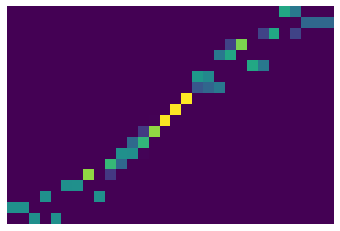

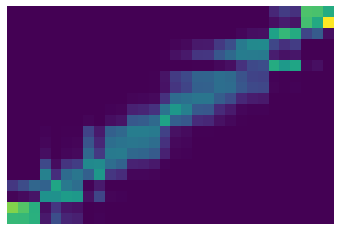

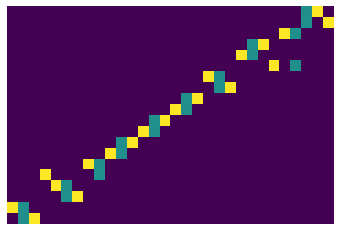

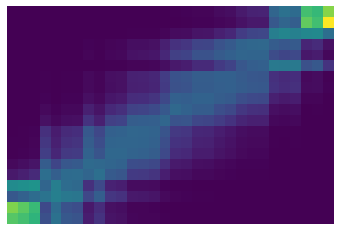


---
Running `alpha=0.1`
---

Running moscot with linesearch

It.  |Loss        |Rel.loss    |Abs. loss   |Difference  |tau         
----------------------------------------------------------------------
    1|1.013683e+04|1.000000e+00|1.013683e+04|1.797870e-01|0.000000e+00
    2|9.300022e+03|8.997881e-02|8.368049e+02|2.002370e-01|0.000000e+00
    3|7.097551e+03|3.103141e-01|2.202470e+03|2.616328e-01|0.000000e+00
    4|8.931336e+03|2.053203e-01|1.833784e+03|2.568191e-01|0.000000e+00
    5|7.308472e+03|2.220524e-01|1.622864e+03|2.524950e-01|0.000000e+00
    6|8.687529e+03|1.587399e-01|1.379057e+03|2.539946e-01|0.000000e+00
    7|7.752747e+03|1.205743e-01|9.347820e+02|2.204426e-01|0.000000e+00
    8|8.562208e+03|9.453886e-02|8.094614e+02|2.026979e-01|0.000000e+00
    9|7.905156e+03|8.311692e-02|6.570522e+02|1.817331e-01|0.000000e+00
   10|8.168572e+03|3.224746e-02|2.634157e+02|4.915325e-02|0.000000e+00
   11|8.020657e+03|1.844174e-02|1.479148e+02|5.589611e-02|0.000000e+00
   12|8.056835e

/Users/marius/miniconda3/envs/py38_devel/lib/python3.8/site-packages/ot/bregman.py:363: RuntimeWarning: divide by zero encountered in true_divide
  v = np.divide(b, KtransposeU)
/Users/marius/miniconda3/envs/py38_devel/lib/python3.8/site-packages/ot/bregman.py:363: RuntimeWarning: overflow encountered in true_divide
  v = np.divide(b, KtransposeU)


It.  |Err         
-------------------
  400|5.147164e-02|
It.  |Err         
-------------------
  600|5.147164e-02|


It.  |Err         
-------------------
  800|5.147164e-02|

Running POT

It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|4.684433e+03|0.000000e+00|0.000000e+00
    1|3.966418e+03|1.810234e-01|7.180146e+02
    2|2.215853e+03|7.900184e-01|1.750565e+03
    3|2.184159e+03|1.451082e-02|3.169395e+01
    4|2.183841e+03|1.457791e-04|3.183583e-01
    5|2.183838e+03|1.457858e-06|3.183725e-03
    6|2.183838e+03|1.457859e-08|3.183727e-05
    7|2.183838e+03|1.457861e-10|3.183732e-07


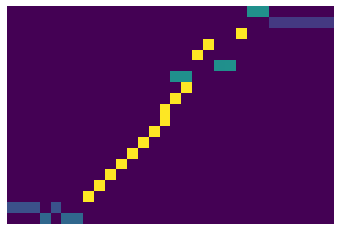

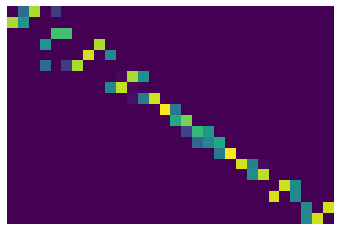

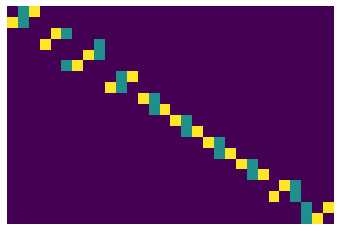

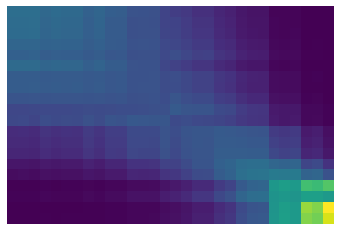


---
Running `alpha=0.5`
---

Running moscot with linesearch

It.  |Loss        |Rel.loss    |Abs. loss   |Difference  |tau         
----------------------------------------------------------------------
    1|5.062154e+04|1.000000e+00|5.062154e+04|1.981557e-01|0.000000e+00
    2|5.306053e+04|4.596628e-02|2.438996e+03|2.619744e-01|0.000000e+00
    3|4.062075e+04|3.062422e-01|1.243979e+04|2.781187e-01|0.000000e+00
    4|4.115676e+04|1.302371e-02|5.360136e+02|2.881509e-01|0.000000e+00
    5|4.181599e+04|1.576505e-02|6.592313e+02|2.466231e-01|0.000000e+00
    6|3.991736e+04|4.756419e-02|1.898637e+03|1.992306e-01|0.000000e+00
    7|4.127501e+04|3.289278e-02|1.357650e+03|1.370576e-01|0.000000e+00
    8|4.026434e+04|2.510069e-02|1.010663e+03|1.117978e-01|0.000000e+00
    9|4.023526e+04|7.227992e-04|2.908202e+01|7.957439e-02|0.000000e+00
   10|4.201164e+04|4.228304e-02|1.776380e+03|7.904905e-02|0.000000e+00
   11|4.166566e+04|8.303822e-03|3.459842e+02|8.659172e-02|0.000000e+00
   12|4.219892e

It.  |Err         
-------------------
  400|6.953325e-02|
It.  |Err         
-------------------
  600|6.953325e-02|


It.  |Err         
-------------------
  800|6.953325e-02|

Running POT

It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|2.342014e+04|0.000000e+00|0.000000e+00
    1|1.973562e+04|1.866940e-01|3.684523e+03
    2|1.106805e+04|7.831158e-01|8.667568e+03
    3|1.091677e+04|1.385788e-02|1.512833e+02
    4|1.091525e+04|1.391900e-04|1.519294e+00
    5|1.091524e+04|1.391961e-06|1.519359e-02
    6|1.091524e+04|1.391962e-08|1.519359e-04
    7|1.091524e+04|1.391961e-10|1.519358e-06


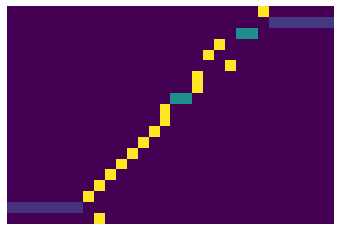

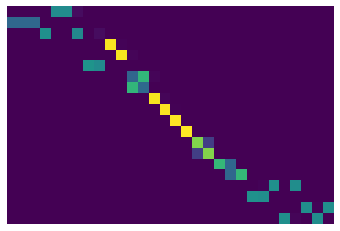

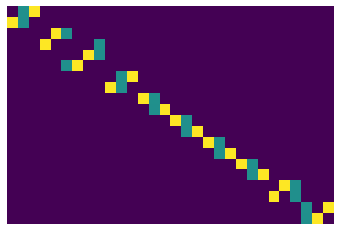

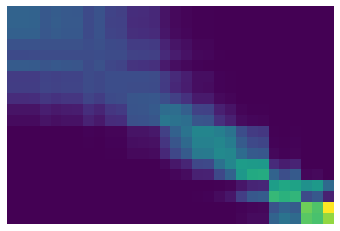

In [196]:
for alpha in [1e-3, 0.1, 0.5]:
    print(f"\n---\nRunning `alpha={alpha}`\n---\n")
    moscot_default, moscot_ns, novosparc_matrix, POT_matrix, epsilon = run_comparison(C1, C2, M, p, q, alpha=alpha, 
                                                                             log=True, epsilon=None, n_iters=20, 
                                                                             tol=1e-9)
    
    # plot and save
    plot_coupling(moscot_default.matrix, axis_off=True, save=f"alpha={alpha}_epsilon={epsilon}_moscot_default.png")
    plot_coupling(moscot_ns.matrix, axis_off=True, save=f"alpha={alpha}_epsilon={epsilon}_moscot_ns.png")
    plot_coupling(POT_matrix, axis_off=True, save=f"alpha={alpha}_epsilon={epsilon}_POT.png")
    plot_coupling(novosparc_matrix, axis_off=True, save=f"alpha={alpha}_epsilon={epsilon}_novosparc.png")


# Look into `alpha=0` and `alpha=1`

## `alpha=0` (reg. W)

In [176]:
coupling_W_reg, loss_W_reg = ot.sinkhorn(p, q, M, reg=1e-2, verbose=True, log=True)

It.  |Err         
-------------------
    0|6.641510e-02|
   10|4.171487e-04|
   20|1.102303e-05|
   30|2.949053e-07|
   40|7.889915e-09|
   50|2.110872e-10|


Plot the coupling

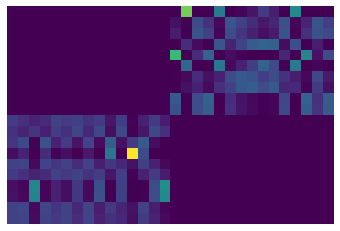

In [177]:
plot_coupling(coupling_W_reg, axis_off=True)

## `alpha=0` (unreg. W)

In [178]:
coupling_W_unreg, loss_W_reg = ot.emd(p, q, M, log=True)

Plot the coupling

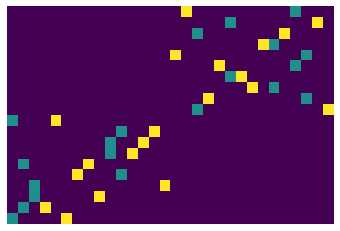

In [179]:
plot_coupling(coupling_W_unreg, axis_off=True)

## `alpha=1` (reg. GW)

In [202]:
# prepare cost matrices for moscot
C1_g = Geometry(cost_matrix=jnp.asarray(C1, dtype=jnp.float64))
C2_g = Geometry(cost_matrix=jnp.asarray(C2, dtype=jnp.float64))
M_g = Geometry(cost_matrix=jnp.asarray(M, dtype=jnp.float64))

# run regularized gromov-wasserstein
GW_object_reg = ott.core.gromov_wasserstein.gromov_wasserstein(C1_g, C2_g, epsilon=2, sinkhorn_kwargs={})

# check for convergence
assert(GW_object.converged_sinkhorn.all()), "Some sinkhorn iterations did not converge"

AssertionError: Some sinkhorn iterations did not converge

Plot coupling matrix

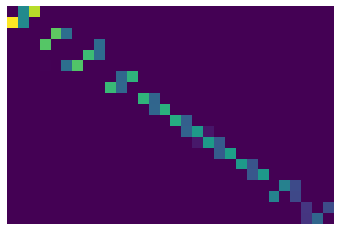

In [181]:
plot_coupling(GW_object_reg.transport, axis_off=True)

In [182]:
print(f"OTT's GW used `epsilon={C1_g.epsilon:.2f}`")

OTT's GW used `epsilon=3.00`


## `alpha=1` (unreg. GW)

In [183]:
coupling_GW_unreg, loss_GW_unreg = ot.gromov.gromov_wasserstein(C1, C2, p, q, loss_fun='square_loss', 
                                        verbose=True, log=True, armijo=True)

It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|4.683978e+04|0.000000e+00|0.000000e+00
    1|3.869487e+04|2.104909e-01|8.144916e+03
    2|2.209704e+04|7.511333e-01|1.659783e+04
    3|2.183217e+04|1.213229e-02|2.648743e+02
    4|2.182951e+04|1.217907e-04|2.658632e+00
    5|2.182948e+04|1.217954e-06|2.658731e-02
    6|2.182948e+04|1.217955e-08|2.658732e-04
    7|2.182948e+04|1.217957e-10|2.658737e-06


Plot the coupling

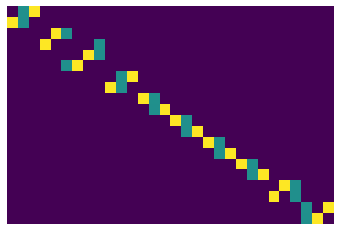

In [184]:
plot_coupling(coupling_GW_unreg, axis_off=True)